In [1]:

import pandas as pd

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False


In [26]:
st_code = "000070.SZ"

def get_file_name_by_st_code(st_code):
    pre_path = "finial_data/"
    income_file_name = pre_path + st_code + "_income.csv"
    asset_file_name = pre_path + st_code + "_asset.csv"
    cash_file_name = pre_path + st_code + "_cash.csv"
    return income_file_name, asset_file_name, cash_file_name


def fill_last_year_value(df, col):
    # 获取起初值，即上一年的末值，如果没有则取当前值
    df[col + "_期初"] = df[col]
    for ix in df.index:
        # ix year - 1 endswith 1231
        last_year_ix = str(int(ix.strftime("%Y")) - 1) + "1231"
        if last_year_ix in df.index:
            # last value > 0 is valid
            if df.loc[last_year_ix, col] > 0:
                df.loc[ix, col + "_期初"] = df.loc[last_year_ix, col]

    return df

# 获取去年同期的值 year - 1 
def fill_last_yoy_value(df, col):
    # 获取起初值，即上一年的末值，如果没有则取当前值
    df[col + "_同期"] = df[col]
    for ix in df.index:
        # ix year - 1 , month and day is same
        last_year_ix = str(int(ix.strftime("%Y")) - 1) + ix.strftime("%m%d")
        if last_year_ix in df.index:
            # last value > 0 is valid
            if df.loc[last_year_ix, col] > 0:
                df.loc[ix, col + "_同期"] = df.loc[last_year_ix, col]

    return df

income_index_name = ['营业总收入*','营业总成本*','营业利润*','利润总额*','营业成本','净利润*', '持续经营净利润','销售费用', '管理费用', '研发费用', '财务费用', '其中：利息费用', '减：利息收入','减：所得税','综合收益总额*','基本每股收益', '稀释每股收益']
asset_index_name = ['货币资金','应收票据及应收账款','预付款项','交易性金融资产',
'其他应收款（合计）','存货','其他流动资产','流动资产总计*','长期应收款','债权投资',
'其他债权投资','长期股权投资','投资性房地产','固定资产（合计）','在建工程（合计）','无形资产','开发支出','商誉','非流动资产合计*','资产总计*','短期借款','流动负债合计*','长期借款','应付债券','长期应付款（合计）','非流动负债合计*','负债合计*','归属于母公司所有者权益合计*','少数股东权益','所有者权益合计*',
]
cash_index_name = ['经营活动产生的现金流量净额*','购建固定资产、无形资产和其他长期资产支付的现金','处置固定资产、无形资产和其他长期资产收回的现金净额','投资活动产生的现金流量净额*','偿还债务支付的现金','筹资活动产生的现金流量净额*']

In [35]:
def cal_base_finial_data(st_code):
    income_file_name, asset_file_name, cash_file_name = get_file_name_by_st_code(st_code)

    income_df = pd.read_csv(income_file_name, index_col=0, parse_dates=True,na_values='--')
    asset_df = pd.read_csv(asset_file_name, index_col=0, parse_dates=True, na_values='--')
    cash_df = pd.read_csv(cash_file_name, index_col=0, parse_dates=True, na_values='--')

    finial_df = pd.concat([income_df[income_index_name], asset_df[asset_index_name], cash_df[cash_index_name]], axis=1).fillna(0)
     # sort by date desc
    finial_df = finial_df.sort_index(ascending=False)
    # rename col '其他应收款（合计）'，固定资产（合计），在建工程（合计）,'长期应付款（合计）' 去掉括号以及合计
    finial_df.rename(columns={'其他应收款（合计）':'其他应收款','固定资产（合计）':'固定资产','在建工程（合计）':'在建工程', '长期应付款（合计）':'长期应付款' }, inplace=True)

    #  息税前利润 = 利润总额 + 利息费用
    finial_df["息税前利润EBIT"] = finial_df["利润总额*"] + finial_df["其中：利息费用"]
    # 盈利能力相关指标
    # 毛利率 = （营业收入-营业成本）/营业收入
    finial_df["毛利率"] = (finial_df["营业总收入*"] - finial_df["营业成本"]) / finial_df["营业总收入*"]
    # 营业利润率 = 营业利润/营业收入
    finial_df["营业利润率"] = finial_df["营业利润*"] / finial_df["营业总收入*"]
    # 净利率 = 净利润/营业收入
    finial_df["净利率"] = finial_df["净利润*"] / finial_df["营业总收入*"]
    # 息税前利润率 = 息税前利润/营业收入
    finial_df["息税前利润率"] = finial_df["息税前利润EBIT"] / finial_df["营业总收入*"]
    # 净资产收益率 = 净利润/净资产
    finial_df["净资产收益率"] = finial_df["净利润*"] / finial_df["所有者权益合计*"]
    # 总资产报酬率 = 净利润/总资产
    finial_df["总资产报酬率"] = finial_df["净利润*"] / finial_df["资产总计*"]
    # 偿债能力 流动性水平
    # 流动比率 = 流动资产/流动负债
    finial_df["流动比率"] = finial_df["流动资产总计*"] / finial_df["流动负债合计*"]
    #  速动比率 =  （流动资产总计-存货-其他流动资产）/流动负债合计
    finial_df["速动比率"] = (finial_df["流动资产总计*"] - finial_df["存货"] - finial_df["其他流动资产"]) / finial_df["流动负债合计*"]
    # 现金比率 = （货币资金+交易性金融资产）/流动负债合计
    finial_df["现金比率"] = (finial_df["货币资金"] + finial_df["交易性金融资产"]) / finial_df["流动负债合计*"]
    # ### 清偿能力
    # DebtRate (资产负债率) = 负债合计/资产总计
    finial_df["资产负债率"] = finial_df["负债合计*"] / finial_df["资产总计*"]
    # DebtEquityRate (权益乘数) = 负债合计/（所有者权益合计-少数股东权益）
    finial_df["权益乘数"] = finial_df["负债合计*"] / (finial_df["所有者权益合计*"] - finial_df["少数股东权益"])
    # InterestCover 利息保障倍数 = EBIT（利润总额+财务费用）/财务费用
    finial_df["利息保障倍数"] = finial_df["息税前利润EBIT"] / finial_df["其中：利息费用"]
    # FreeCashFlow 自由现金流量 = 经营活动产生的现金流量净额-资本支出（构建固定资产、无形资产和其他长期资产支付的现金-处置固定资产、无形资产和其他长期资产收回的现金净额）
    finial_df["自由现金流量"] = finial_df["经营活动产生的现金流量净额*"] - (finial_df["购建固定资产、无形资产和其他长期资产支付的现金"] - finial_df["处置固定资产、无形资产和其他长期资产收回的现金净额"])
    ### 现金流情况
    # CashFlowRate 现金流量比率 = 经营活动产生的现金流量净额/营业收入
    finial_df["现金流量比率"] = finial_df["经营活动产生的现金流量净额*"] / finial_df["营业总收入*"]
    # 债务保障倍数 = 经营活动产生的现金流量净额/（流动负债合计+长期借款）
    finial_df["债务保障倍数"] = finial_df["经营活动产生的现金流量净额*"] / (finial_df["流动负债合计*"] + finial_df["长期借款"])
    # 自由现金流与经营活动净现金流比率 = 自由现金流/经营活动产生的现金流量净额
    finial_df["自由现金流与经营活动净现金流比率"] = finial_df["自由现金流量"] / finial_df["经营活动产生的现金流量净额*"]
    finial_df = fill_last_year_value(finial_df, "存货")
    finial_df = fill_last_yoy_value(finial_df, "存货")
    # 应收账款
    finial_df = fill_last_year_value(finial_df, "应收票据及应收账款")
    finial_df = fill_last_yoy_value(finial_df, "应收票据及应收账款")
    # 固定资产
    finial_df = fill_last_year_value(finial_df, "固定资产")
    finial_df = fill_last_yoy_value(finial_df, "固定资产")
    # 资产总计
    finial_df = fill_last_year_value(finial_df, "资产总计*")
    finial_df = fill_last_yoy_value(finial_df, "资产总计*")
    # 净资产
    finial_df = fill_last_year_value(finial_df, "所有者权益合计*")
    finial_df = fill_last_yoy_value(finial_df, "所有者权益合计*")
    # 负债合计
    finial_df = fill_last_year_value(finial_df, "负债合计*")
    finial_df = fill_last_yoy_value(finial_df, "负债合计*")
    # ### 营运能力
    # InventoryTurnoverRate 存货周转率 = 营业成本/平均存货(存货+期初存货)/2
    finial_df["存货周转率"] = finial_df["营业成本"] / ((finial_df["存货"] + finial_df["存货_期初"]) / 2)
    # AccountRecvTurnover 应收账款周转率 = 营业收入/平均应收账款(应收账款+期初应收账款)/2
    finial_df["应收账款周转率"] = finial_df["营业总收入*"] / ((finial_df["应收票据及应收账款"] + finial_df["应收票据及应收账款_期初"]) / 2)
    # FixAssetTurnover 固定资产周转率 = 营业收入/平均固定资产(固定资产+期初固定资产)/2
    finial_df["固定资产周转率"] = finial_df["营业总收入*"] / ((finial_df["固定资产"] + finial_df["固定资产_期初"]) / 2)
    # TotalAssetTurnover 总资产周转率 = 营业收入/平均总资产(资产总计+期初资产总计)/2
    finial_df["总资产周转率"] = finial_df["营业总收入*"] / ((finial_df["资产总计*"] + finial_df["资产总计*_期初"]) / 2)
    # # 需要计算期初值：存货、应收账款、固定资产、资产总计: 为上一年的末值，即取最近的上一个index=1231日期的值，如果没有则去当前index的值
    finial_df = fill_last_yoy_value(finial_df, "营业总收入*")
    finial_df = fill_last_yoy_value(finial_df, "净利润*")
    finial_df = fill_last_yoy_value(finial_df, "所有者权益合计*")
    ### 成长能力
    # 营业收入增长率 = （本期营业收入-上期营业收入）/上期营业收入
    finial_df["营业收入增长率"] = (finial_df["营业总收入*"] - finial_df["营业总收入*_同期"]) / finial_df["营业总收入*_同期"]
    # 净利润增长率 = （本期净利润-上期净利润）/上期净利润
    finial_df["净利润增长率"] = (finial_df["净利润*"] - finial_df["净利润*_同期"]) / finial_df["净利润*_同期"]
    # 净资产增长率 = （本期净资产（所有者权益合计）-上期净资产）/上期净资产
    finial_df["净资产增长率"] = (finial_df["所有者权益合计*"] - finial_df["所有者权益合计*_同期"]) / finial_df["所有者权益合计*_同期"]
    # 总资产增长率 = （本期总资产（资产总计）-上期总资产）/上期总资产
    finial_df["总资产增长率"] = (finial_df["资产总计*"] - finial_df["资产总计*_同期"]) / finial_df["资产总计*_同期"]
    # 固定资产增长率 = （本期固定资产-上期固定资产）/上期固定资产
    finial_df["固定资产增长率"] = (finial_df["固定资产"] - finial_df["固定资产_同期"]) / finial_df["固定资产_同期"]
    # 存货增长率 = （本期存货-上期存货）/上期存货
    finial_df["存货增长率"] = (finial_df["存货"] - finial_df["存货_同期"]) / finial_df["存货_同期"]
    # 经营性资产 = 总资产-现金-长期股权投资-投资性房地产
    finial_df["经营性资产"] = finial_df["资产总计*"] - finial_df["货币资金"] - finial_df["长期股权投资"] - finial_df["投资性房地产"]
    # 经营性负债 = 总资产-短期借款-长期借款-归属于母公司所有者权益合计-少数股东权益
    finial_df["经营性负债"] = finial_df["资产总计*"] - finial_df["短期借款"] - finial_df["长期借款"] - finial_df["归属于母公司所有者权益合计*"] - finial_df["少数股东权益"]
    # 经营性净资产
    finial_df["经营性净资产"] = finial_df["经营性资产"] - finial_df["经营性负债"]
    finial_df = fill_last_year_value(finial_df, "经营性净资产")
    finial_df = fill_last_yoy_value(finial_df, "经营性净资产")
    # 资产收益率 ROA = 净利润/ 平均总资产(资产总计+期初资产总计)/2
    finial_df["资产收益率ROA"] = finial_df["净利润*"] / ((finial_df["资产总计*"] + finial_df["资产总计*_期初"]) / 2)
    # 权益收益率 ROE = 净利润/ 平均净资产(所有者权益合计+期初所有者权益合计)/2
    finial_df["权益收益率ROE"] = finial_df["净利润*"] / ((finial_df["所有者权益合计*"] + finial_df["所有者权益合计*_期初"]) / 2)
    # 投资资本收益率 ROIC = 息税前利润*(1-所得税税率) / (固定资产+无形资产+流动资产-流动负债-现金)
    finial_df["投资资本收益率ROIC"] = finial_df["息税前利润EBIT"] * (1 - finial_df["减：所得税"] / finial_df["利润总额*"]) / (finial_df["固定资产"] + finial_df["无形资产"] + finial_df["流动资产总计*"] - finial_df["流动负债合计*"] - finial_df["货币资金"])
    # 经营性资产周转率 = 营业收入 / 平均净经营性资产
    finial_df["经营性资产周转率"] = finial_df["营业总收入*"] / ((finial_df["经营性净资产"] + finial_df["经营性净资产_期初"]) / 2)
    # ROE 净资产收益率 = 净利润/平均净资产 = 净利润/营业收入 * 营业收入/总资产 * 总资产/平均净资产
    # 权益乘数 = 总资产/平均净资产
    finial_df["权益乘数"] = finial_df["资产总计*"] / ((finial_df["所有者权益合计*"] + finial_df["所有者权益合计*_期初"]) / 2)

    return finial_df.fillna(0)


In [36]:
df = cal_base_finial_data("600519.SH")

In [37]:
ab = df[["固定资产增长率", "存货增长率", "总资产增长率",  "净利润增长率", "营业收入增长率"]]

In [40]:
df.head(10)

,营业总收入*,营业总成本*,营业利润*,利润总额*,营业成本,净利润*,持续经营净利润,销售费用,管理费用,研发费用,...,存货增长率,经营性资产,经营性负债,经营性净资产,经营性净资产_期初,经营性净资产_同期,资产收益率ROA,权益收益率ROE,投资资本收益率ROIC,经营性资产周转率
报告期,,,,,,,,,,,,,,,,,,,,,
2022-09-30,8.978588e+10,2.789089e+10,6.196155e+10,6.191642e+10,7.082313e+09,4.631399e+10,4.631399e+10,2.405740e+09,5.568896e+09,1.149345e+08,...,0.157622,1.896065e+11,3.431035e+10,1.552961e+11,1.451420e+11,1.301076e+11,0.184178,0.225699,0.359278,0.597700
2022-06-30,5.944352e+10,1.785403e+10,4.163479e+10,4.163992e+10,4.546488e+09,3.110536e+10,3.110536e+10,1.507141e+09,3.632969e+09,6.011991e+07,...,0.138668,1.817954e+11,4.139273e+10,1.404027e+11,1.451420e+11,1.133610e+11,0.125674,0.157331,0.266449,0.416352
2022-03-31,3.318716e+10,9.185980e+09,2.402687e+10,2.401112e+10,2.464917e+09,1.795212e+10,1.795212e+10,5.309537e+08,2.133083e+09,1.954151e+07,...,0.140638,1.949204e+11,3.639361e+10,1.585268e+11,1.451420e+11,1.317411e+11,0.070891,0.087175,0.133239,0.218575
2021-12-31,1.094643e+11,3.477690e+10,7.475088e+10,7.452803e+10,8.983378e+09,5.572053e+10,5.572053e+10,2.737369e+09,8.450274e+09,6.192321e+07,...,0.156752,2.033527e+11,5.821069e+10,1.451420e+11,1.316296e+11,1.316296e+11,0.237835,0.305587,0.458235,0.791008
2021-09-30,7.705315e+10,2.407186e+10,5.302296e+10,5.285609e+10,6.574930e+09,3.957496e+10,3.957496e+10,1.923138e+09,5.414713e+09,4.210492e+07,...,0.126449,1.739950e+11,4.388731e+10,1.301076e+11,1.316296e+11,1.270963e+11,0.180667,0.227093,0.363568,0.588783
2021-06-30,5.072158e+10,1.569777e+10,3.507177e+10,3.505100e+10,4.232098e+09,2.620668e+10,2.620668e+10,1.290652e+09,3.487194e+09,2.309382e+07,...,0.165835,1.586654e+11,4.530445e+10,1.133610e+11,1.316296e+11,1.170655e+11,0.122960,0.156325,0.275528,0.414070
2021-03-31,2.806474e+10,8.355908e+09,1.971406e+10,1.969488e+10,2.269951e+09,1.477203e+10,1.477203e+10,5.670696e+08,1.780458e+09,1.142661e+07,...,0.171797,1.644695e+11,3.272842e+10,1.317411e+11,1.316296e+11,1.360519e+11,0.068929,0.084361,0.130914,0.213120
2020-12-31,9.799324e+10,3.130513e+10,6.663508e+10,6.619694e+10,8.154001e+09,4.952333e+10,4.952333e+10,2.547746e+09,6.789844e+09,5.039804e+07,...,0.141751,1.773047e+11,4.567513e+10,1.316296e+11,1.286246e+11,1.286246e+11,0.249841,0.319921,0.439715,0.753058
2020-09-30,6.957488e+10,2.153273e+10,4.798582e+10,4.787869e+10,5.830896e+09,3.585067e+10,3.585067e+10,1.775857e+09,4.549516e+09,3.789487e+07,...,0.135757,1.575039e+11,3.040754e+10,1.270963e+11,1.286246e+11,1.809318e+10,0.195041,0.242195,0.331568,0.544147


<AxesSubplot: xlabel='报告期'>

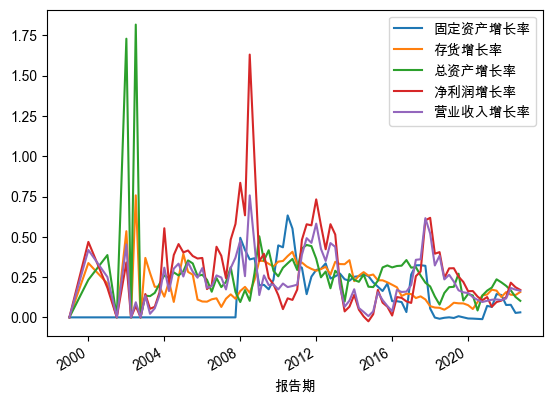

In [8]:
# finial_df.head()

In [9]:
# finial_df.columns


In [10]:
# finial_df["日期"]

In [11]:
finial_df.describe()

NameError: name 'finial_df' is not defined

In [ ]:
finial_df = fill_last_year_value(finial_df, "存货")

In [ ]:
# finial_df[["存货_期初","存货_同期", "存货"]].plot(figsize=(15, 10))

In [ ]:
def get_realative_last_year_end_value(df, col):
    for x in df.index:
        cur_date = df.loc[x, "日期"]
        print(cur_date)
        # 日期年份减1，日期固定为1231
        last_year = str(int(cur_date[:4]) - 1) + "1231"
        print(last_year)
        # 如果上一年的末值存在，则取上一年的末值
        if last_year in df["日期"].values:
            return df.loc[last_year, col]
        # 如果上一年的末值不存在，则取当前值
        else:
            return df.loc[cur_date, col]




In [ ]:

finial_df["存货_期初"] = finial_df.apply(get_realative_last_year_end_value, col="存货", axis=1)

finial_df["存货_期初"]

In [ ]:
for x in finial_df["存货"].index:
    print(x)

In [ ]:
finial_df["日期"][:4]

In [ ]:
finial_df["日期"] = finial_df.index.strftime("%Y%m%d") # type: ignore

In [ ]:
finial_df["日期"]

In [ ]:
finial_df["其中：利息费用"]